In [61]:
# Benchmark all the different variations of dace convolution
# Benchmark it with respect to cudnn, pytorch's conv2D
# 1DConv, 2DConv, 3DConv
# Verification and benchmarking

In [79]:
from torch import nn
import click
import dace
import numpy as np
from pprint import pprint
import dace.libraries.blas
import matplotlib.pyplot as plt
import tensorflow as tf

In [80]:
def barplot(title, labels=False):
    x = list(sorted(TIMES.keys()))
    bars = [np.median(TIMES[key].timings) for key in x]
    yerr = [np.std(TIMES[key].timings) for key in x]
    color = [('#86add9' if 'dace' in key else 'salmon') for key in x]

    p = plt.bar(x, bars, yerr=yerr, color=color)
    plt.ylabel('Runtime [s]'); plt.xlabel('Implementation'); plt.title(title); 
    if labels:
        plt.gca().bar_label(p)
    pass

In [81]:
# Define symbolic sizes for arbitrary inputs
rows = dace.symbol('rows')
cols = dace.symbol('cols')
indepth = dace.symbol('indepth')
inputimages = dace.symbol('inputimages')
outdepth = dace.symbol('outdepth')
chunklength = dace.symbol('chunklength', dtype=dace.int64, integer=True, positive=True)

w = dace.symbol('w')

# Define data type to use
dtype = dace.float64
np_dtype = np.float64

In [82]:
# Different convolution versions
@dace.program(auto_optimize=True, device=dace.DeviceType.GPU)
def convolutionallreduce(Input: dtype[inputimages, rows, cols, indepth], 
                           kernel: dtype[ w, w, indepth, outdepth], 
                           Output: dtype[inputimages, rows, cols, outdepth]):
    tmp = np.zeros([inputimages, rows, cols, indepth*w*w, outdepth], dtype = Input.dtype)
    for i,j,d,od,m,n in dace.map[w/2:rows-w/2, w/2:cols-w/2,0:indepth,0:outdepth, 0:w, 0:w]:
        with dace.tasklet:
            in_A << Input[0, i - w/2 + m, j - w/2 + n, d]
            in_B << kernel[m, n, d, od]
            out >> tmp[0, i, j, (d*(w*w)) + (m*w)+n, od]

            out = in_A * in_B

    dace.reduce(lambda a,b:a+b, tmp, Output, axis=3, identity=0)


# Simple convolution
@dace.program(auto_optimize=True, device=dace.DeviceType.GPU)
def convolutionsimple(Input: dtype[inputimages, rows, cols, indepth], 
                      kernel: dtype[ w, w, indepth, outdepth], 
                      Output: dtype[inputimages, rows, cols, outdepth]):
    Output[:] = 0
    for i,j,d,od,m,n in dace.map[w/2:rows-w/2, w/2:cols-w/2,0:indepth,0:outdepth, 0:w, 0:w]:
            Output[0, i, j, od] += Input[0, i - w / 2 + m, j - w / 2 + n, d] * kernel[ m, n, d, od]




# Split into parallel and non parallel maps
# TODO: Find why auto optimize is not working for simpleparallel
@dace.program(device=dace.DeviceType.GPU)
def convolutionsimpleparallel(Input: dtype[inputimages, rows, cols, indepth],
                              kernel: dtype[ w, w, indepth, outdepth],
                              Output: dtype[inputimages, rows, cols, outdepth]
                              ):
    Output[:] = 0

    for i, j, od in dace.map[w/2:rows-w/2, w/2:cols-w/2, 0:outdepth]:
        tmp = np.zeros([1], dtype = Input.dtype)
        for d,m,n in dace.map[0:indepth,0:w,0:w]:
            tmp = tmp + Input[0, i - w / 2 + m, j - w / 2 + n, d] * kernel[m, n, d, od]
        Output[0,i,j,od] = tmp

        

# # Reduction along input depth
# @dace.program(auto_optimize=True, device=dace.DeviceType.GPU)
# def convolutionindepthreduce(Input: dtype[inputimages,rows, cols, indepth], 
#                              kernel: dtype[ w, w, indepth, outdepth], 
#                              Output: dtype[inputimages, rows, cols, outdepth]):
#     for i, j, od in dace.map[w/2:rows-w/2, w/2:cols-w/2, 0:outdepth]:
#         tmp = np.zeros([indepth*w*w], dtype = Input.dtype)
#         for d,m,n in dace.map[0:indepth,0:w,0:w]:
#             with dace.tasklet:
#                 in_A << Input[0, i - w / 2 + m, j - w / 2 + n, d]
#                 in_B << kernel[m, n, d, od]
#                 out >> tmp[(d*(w*w)) + (m*w)+n]

#                 out = in_A * in_B
#         Output[0,i,j,od] = dace.reduce(lambda a, b: a + b, tmp, identity=0)        

In [83]:
# Prepare data with numpy
#Input = np.random.rand(InChannels, Rows, Cols).astype(np_dtype)
#kernel = np.random.rand(OutChannels, InChannels, W, W).astype(np_dtype)
#Output = np.zeros((OutChannels, Rows, Cols), dtype=np_dtype)
InputImages = 1
Rows = 9
Cols = 9
InChannels = 1
OutChannels = 2
W = 3
Stride = 1 # TODO: Code dace convolutions with stride

# Prepare data with numpy
Input = np.random.rand(InputImages, Rows, Cols, InChannels).astype(np_dtype)
kernel = np.random.rand(W, W, InChannels, OutChannels).astype(np_dtype)
Output = np.zeros((InputImages, Rows, Cols, OutChannels), dtype=np_dtype)

In [84]:
convolutionsimple(Input, kernel, Output)
opdace = tf.convert_to_tensor(Output)
opdace = opdace[:,int(W/2):Rows-int(W/2),int(W/2):Cols-int(W/2),:]
input = tf.convert_to_tensor(Input)
filter = tf.convert_to_tensor(kernel)

op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding="VALID")

if(sum(sum(sum(sum(opdace-op))))==0):
    print("Verification successfull")



# Place holder function for tf gpu code.
def timetfgpu():
    op=tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')

/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/sdfg.py:1887: UserWarning: SDFG "convolutionsimple" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


Verification successfull


In [85]:
# Warmup
%timeit -r 1 -n 1 convolutionallreduce(Input, kernel, Output)
%timeit -r 1 -n 1 convolutionsimple(Input, kernel, Output)
%timeit -r 1 -n 1 convolutionindepthreduce(Input, kernel, Output)
%timeit -r 1 -n 1 convolutionsimpleparallel(Input, kernel, Output)
%timeit -r 1 -n 1 timetfgpu()

/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/libraries/standard/nodes/reduce.py:458: UserWarning: Multiple axis reductions not supported with this expansion. Falling back to the pure expansion.
  warnings.warn('Multiple axis reductions not supported with this expansion. '
/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/nodes.py:587: UserWarning: Reduce maps to unused symbol(s): {'indepth', 'cols', 'w', 'rows', 'inputimages', 'outdepth'}
  warnings.warn(f"{self.label} maps to unused symbol(s): {extra_symbols}")
/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/sdfg.py:1887: UserWarning: SDFG "convolutionallreduce" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
58.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
45.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/propagation.py:1353: UserWarning: Subset union failed between 0:inputimages, 0:rows, 0:cols, 0:indepth and 0, i - 0.5*w:i + 0.5*w, j - 0.5*w:j + 0.5*w, 0:indepth 
  warnings.warn('Subset union failed between %s and %s ' % (old_subset, tmp_subset))
/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/propagation.py:1353: UserWarning: Subset union failed between 0, i - 0.5*w:i + 0.5*w, j - 0.5*w:j + 0.5*w, 0:indepth and 0:inputimages, 0:rows, 0:cols, 0:indepth 
  warnings.warn('Subset union failed between %s and %s ' % (old_subset, tmp_subset))
/home/akanksha/spcl/dacelocal/venv/lib/python3.8/site-packages/dace/sdfg/sdfg.py:1887: UserWarning: SDFG "convolutionsimpleparallel" is already loaded by another object, recompiling under a different name.
  warnings.warn('SDFG "%s" is already loaded by another object, '


3.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
666 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
%%timeit -r 1 -n 1
    op=tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')

804 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [87]:
TIMES = {}
TIMES['dace_simple'] = %timeit -o convolutionsimple(Input, kernel, Output)
TIMES['dace_allreduce'] = %timeit -o convolutionallparallel(Input, kernel, Output)
TIMES['dace_simpleparallel'] = %timeit -o convolutionsimpleparallel(Input, kernel, Output)
TIMES['tfgpu'] = %timeit -o timetfgpu()

45.7 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.4 ms ± 792 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
44.9 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
149 µs ± 364 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


[0.0007922448326744664, 0.0005237049326466924, 0.0005481221850110665, 3.6353583029828773e-07]
[ -7.14064008  -7.55458214  -7.50901233 -14.82738797]


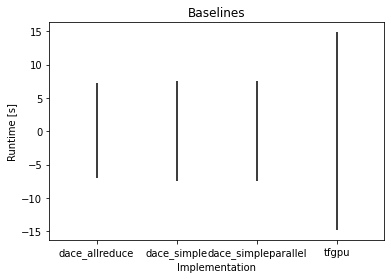

In [88]:
barplot('Baselines')